In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

##### Files
|Name|Description|
|:-|:-|
|umap.csv|umap of each cell requested from author of MultiVI (DOI:10.1038/s41587-022-01476-y)|
|pseudotime.csv|pseudotime of each cell, requested from author of MultiVI (DOI:10.1038/s41587-022-01476-y)|
|greenleaf-final-RNA_wox_filter_hvg_rm_dc1r3_r1.h5ad|preprocessed file used for training|
|result_ep20.npz|Embeding|

In [2]:
f = np.load('../result/result_ep20.npz')
rna_embed = pd.DataFrame(f['cell_embed_RNA'], index=f['RNA_id'])
atac_embed = pd.DataFrame(f['cell_embed_ATAC'], index=f['RNA_id'])

In [3]:
gl = sc.read('../data/greenleaf-final-RNA_wox_filter_hvg_rm_dc1r3_r1.h5ad')
gl = gl[f['RNA_id']]
cells = list(gl.obs.cells)

In [4]:
gl.obs['celltype'] = gl.obs.celltype.map({'Cyc. Prog.':'Cyc. Prog.', 'mGPC/OPC':'mGPC/OPC', 'SP':'SP', 'RG':'RG/Astro', 'nIPC/GluN1':'nIPC/ExN', 'GluN3':'ExM', 'GluN2':'ExUp', 'GluN4': 'ExDp', 'GluN5': 'ExDp'})
gl.obs.set_index('cells', inplace=True)
ptime = pd.read_csv('data/pseudotime.txt', sep="\t", index_col=0)[['latent_time']]
common_cells = list(set(cells) & set(ptime.index))
ct = list(gl[common_cells,].obs.celltype)

/home/QShe/miniconda3/envs/R/lib/python3.7/site-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.


In [5]:
rna_cells = list(map(lambda x: f'{x}-RNA', common_cells))
atac_cells = list(map(lambda x: f'{x}-ATAC', common_cells))
pd.DataFrame({'rna':rna_cells, 'atac':atac_cells, 'celltype':ct, 'time': list(ptime.loc[common_cells,'latent_time'])}).to_csv('celltype_time.tsv',sep="\t", index=False)

#### Similarity

##### cosine similarity between embeddings

In [5]:
rna_m = rna_embed.values
atac_m = atac_embed.values

In [6]:
def get_cos_sim(v1: list, v2: list):
    num = float(np.dot(v1, v2))
    denom = np.linalg.norm(v1) * np.linalg.norm(v2)
    return 0.5 + 0.5 * (num / denom) if denom != 0 else 0

In [7]:
result = list()
for i in range(0, rna_m.shape[0]):
    result.append(get_cos_sim(rna_m[i,], atac_m[i,]))

In [8]:
pd.DataFrame.from_dict({'cell':cells, 'sim':result}).to_csv('similarity.tsv', sep="\t", index=False)

##### pair-wise cosine similarity between multi-modal embedding

In [9]:
result = list()
for i in range(0, atac_m.shape[0]):
    dist = list()
    for j in range(0, rna_m.shape[0]):
        dist.append(get_cos_sim(atac_m[i,], rna_m[j,]))
    result.append(dist)

In [10]:
rna_cells = list(map(lambda x: f'{x}-RNA', cells))
atac_cells = list(map(lambda x: f'{x}-ATAC', cells))
cos_m = pd.DataFrame(result, index=atac_cells, columns=rna_cells)
cos_m.to_csv('pair_sim_matrix.csv')

#### visualize

In [11]:
sim = pd.read_csv('similarity.tsv', sep="\t")
sim.set_index('cell', inplace=True)

In [12]:
adata_hvg = sc.read('../data/greenleaf-final-RNA_wox_filter_hvg_rm_dc1r3_r1.h5ad')
adata_hvg.obs.index = adata_hvg.obs.cells
adata_hvg.var.index = adata_hvg.var.gene_name

In [13]:
adata_hvg = adata_hvg[list(set(adata_hvg.obs_names) & set(sim.index))]

In [14]:
umap = pd.read_csv('data/umap.txt', sep="\t", index_col=0)
ptime = pd.read_csv('data/pseudotime.txt', sep="\t", index_col=0)
ptime = ptime[['cluster', 'latent_time']]

In [15]:
common_cells = list(set(adata_hvg.obs_names) & set(umap.index) & set(ptime.index))
adata = adata_hvg[common_cells]

In [16]:
adata.obs.loc[:,'sim'] = sim.loc[adata.obs_names,'sim']
adata.obs.loc[:,'time'] = ptime.loc[adata.obs_names,'latent_time']
adata.obsm['X_umap'] = umap.loc[common_cells,:].to_numpy()

/home/QShe/miniconda3/envs/R/lib/python3.7/site-packages/pandas/core/indexing.py:1667: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value
/home/QShe/miniconda3/envs/R/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [17]:
adata.obs['celltype'] = adata.obs.celltype.map({'Cyc. Prog.':'Cyc. Prog.', 'mGPC/OPC':'mGPC/OPC', 'SP':'SP', 'RG':'RG/Astro', 'nIPC/GluN1':'nIPC/ExN', 'GluN3':'ExM', 'GluN2':'ExUp', 'GluN4': 'ExDp', 'GluN5': 'ExDp'})
adata.obs.celltype = adata.obs.celltype.astype("category")
adata.obs.celltype = adata.obs.celltype.cat.reorder_categories(
    ['Cyc. Prog.','mGPC/OPC','RG/Astro','nIPC/ExN','ExM','ExUp','ExDp','SP']
)

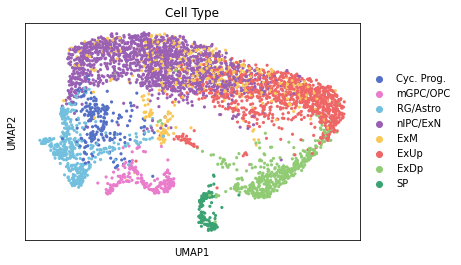

In [18]:
sc.pl.embedding(adata, basis='umap', color='celltype', title='Cell Type', size=40, palette=['#5470c6','#ea7ccc','#73c0de','#9a60b4','#fac858','#ee6666','#91cc75','#3ba272'], sort_order=False)

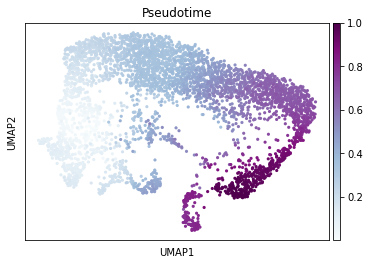

In [19]:
sc.pl.embedding(adata, basis='umap', color='time', title='Pseudotime', color_map = 'BuPu', size=40)

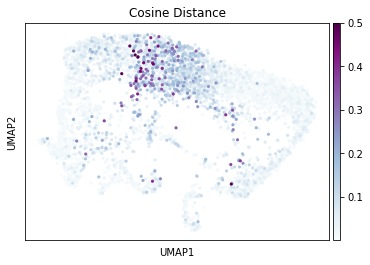

In [20]:
adata.obs['dist'] = 1 - adata.obs.sim
sc.pl.embedding(adata, basis='umap', color='dist', color_map='BuPu', size=40, title="Cosine Distance")

##### Heatmap

In [ ]:
import os
os.system('Rscript heatmap.R')